# West Nile Vius Project

## Import Libraries

In [26]:
import pandas as pd 
import numpy as np
import seaborn as sns
import io
from math import radians, sin, cos, asin, sqrt

from vincenty import vincenty 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV




import time
from datetime import datetime
%autocall 1

Automatic calling is: Smart


## Import Data

In [27]:
train = pd.read_csv("west_nile/input/train.csv")
test = pd.read_csv("west_nile/input/test.csv")
spray = pd.read_csv("west_nile/input/spray.csv")
weather = pd.read_csv("west_nile/input/weather.csv")
sample = pd.read_csv('west_nile/input/SampleSubmission.csv')


In [28]:
train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [29]:
spray.head(2)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163


## EDA

In [30]:
def EDA(df,name):
    null_vals = df.isnull().sum()
    shape = df.shape
    dtypes = df.dtypes
    df_output = pd.DataFrame()
    df_output["Nulls"] = null_vals
    df_output["dtypes"] = dtypes
    print("=======================================\n")
    print(name.upper())
    print("SHAPE:",df_output.shape,"\n")
    return df_output

In [31]:
print(EDA(train,"train"))
print(EDA(test,"test"))
print(EDA(spray,"spray"))
print(EDA(weather,'weather'))
print(EDA(sample,'sample'))


TRAIN
SHAPE: (12, 2) 

                        Nulls   dtypes
Date                        0   object
Address                     0   object
Species                     0   object
Block                       0    int64
Street                      0   object
Trap                        0   object
AddressNumberAndStreet      0   object
Latitude                    0  float64
Longitude                   0  float64
AddressAccuracy             0    int64
NumMosquitos                0    int64
WnvPresent                  0    int64

TEST
SHAPE: (11, 2) 

                        Nulls   dtypes
Id                          0    int64
Date                        0   object
Address                     0   object
Species                     0   object
Block                       0    int64
Street                      0   object
Trap                        0   object
AddressNumberAndStreet      0   object
Latitude                    0  float64
Longitude                   0  float64
AddressAccuracy  

In [32]:
# date is an object , convert to a numeric
def convert_date(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [33]:
convert_date(train)
convert_date(test)
convert_date(weather)

In [34]:
#spray date
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])
spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [35]:
spray.head()

,Date,Time,Latitude,Longitude,am_pm
0,2011-08-29,1900-01-01 06:56:58,42.391623,-88.089163,PM
1,2011-08-29,1900-01-01 06:57:08,42.391348,-88.089163,PM
2,2011-08-29,1900-01-01 06:57:18,42.391022,-88.089157,PM
3,2011-08-29,1900-01-01 06:57:28,42.390637,-88.089158,PM
4,2011-08-29,1900-01-01 06:57:38,42.390410,-88.088858,PM


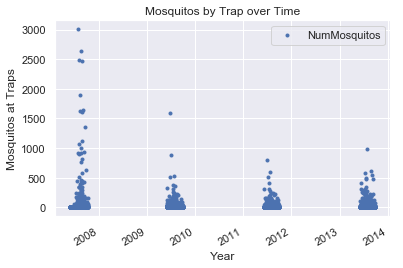

In [36]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time')
plt.xlabel('Year')
plt.ylabel('Mosquitos at Traps');

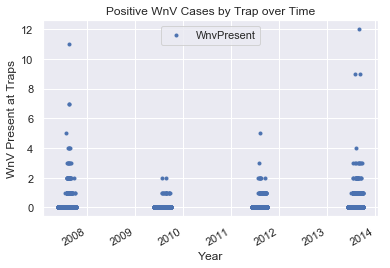

In [37]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(style = '.')
# test[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
#     .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Positive WnV Cases by Trap over Time')
plt.xlabel('Year')
plt.ylabel('WnV Present at Traps');

## Preprocessing - Synthetic Features and Dropping Columns

In [38]:
#John's code for latlong
train['LatLong'] = list(zip(train.Latitude, train.Longitude))
test['LatLong'] = list(zip(test['Latitude'], test['Longitude']))

In [39]:
#Calculate closest station using vincenty
station1 = (41.995, -87.933)
station2 = (41.786, -87.752)

#Create closest station column
train['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in train['LatLong'] ]
test['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in test['LatLong'] ]

In [40]:
weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir'], inplace = True)

In [42]:
#filling in missing(M) and trace(T)
weather_dataset = weather.columns.tolist()

for col in weather_dataset:
    for row in range(weather.shape[0]):
        if weather.loc[row, col] == 'M' or weather.loc[row, col] == '  T':
            weather.loc[row, col] = weather.loc[row - 1, col]

In [43]:
#CONVERT OBJECT TYPES TO NUMBERIC
weather_object_dtypes = ['Tavg', 'WetBulb', 'PrecipTotal']

for col in weather_object_dtypes:
    weather[col] = pd.to_numeric(weather[col])

In [44]:
weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
0,1,2007-05-01,83,50,67,51,56,0.0
1,2,2007-05-01,84,52,68,51,57,0.0
2,1,2007-05-02,59,42,51,42,47,0.0


In [45]:
#merge weather data with train and test data
train = train.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])
test = test.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])

In [46]:
train2 = train.copy()
train2[train2["WnvPresent"] == 1]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,WnvPresent,LatLong,Closest_Station,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
553,2007-07-18,"3800 East 115th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,38,E 115TH ST,T215,"3800 E 115TH ST, Chicago, IL",41.686398,-87.531635,8,...,1,"(41.686398, -87.531635)",2,2,85,69,77,69,71,0.92
603,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,...,1,"(41.673408, -87.599862)",2,2,83,70,77,60,66,0.00
611,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,...,1,"(41.673408, -87.599862)",2,2,83,70,77,60,66,0.00
618,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,...,1,"(41.673408, -87.599862)",2,2,83,70,77,60,66,0.00
660,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,...,1,"(41.673408, -87.599862)",2,2,83,70,77,60,66,0.00
661,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,...,1,"(41.673408, -87.599862)",2,2,83,70,77,60,66,0.00
777,2007-08-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1,"(41.95469, -87.800991)",1,1,92,69,81,62,69,0.00
778,2007-08-01,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1,"(41.95469, -87.800991)",1,1,92,69,81,62,69,0.00
784,2007-08-01,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,1,"(41.974089, -87.824812)",1,1,92,69,81,62,69,0.00
812,2007-08-01,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,...,1,"(41.688324, -87.676709)",2,2,91,69,80,63,70,0.00


<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x000002E7ED78B7B8>>

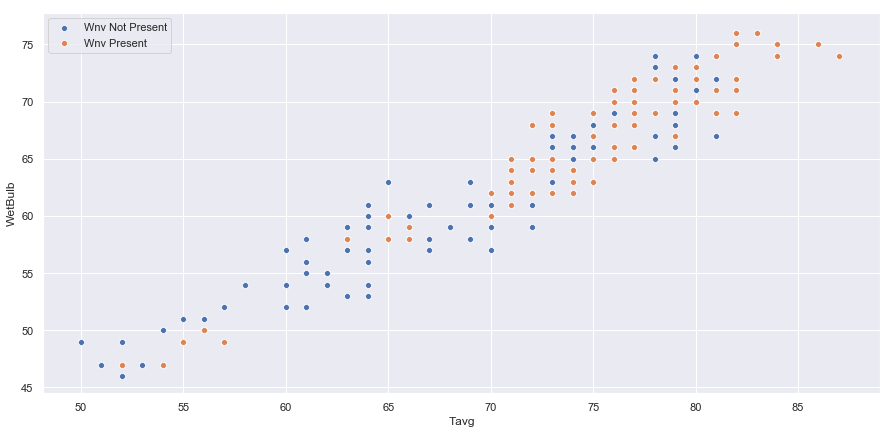

In [64]:
plt.subplots(figsize=(15,7))
#plt.title("Number of Mosquitos with West Nile Virus Per Species")
sns.set()
#ax = sns.scatterplot(x="Tavg", y="DewPoint", hue="WnvPresent",style = "WnvPresent",size = "WnvPresent" ,data=train2)
ax = sns.scatterplot(x="Tavg", y="WetBulb", data=train2[train2["WnvPresent"] == 0],label = "Wnv Not Present")
sns.scatterplot(x="Tavg", y="WetBulb", data=train2[train2["WnvPresent"] == 1], label = "Wnv Present")
ax.legend

In [48]:
# Drop num mosquitos column, not present in test set
train.drop(columns = 'NumMosquitos', inplace = True)

In [49]:
def mosquito(df):
    #split wnv transmitting mosquito species lines into separate columns
    df['CULEX PIPIENS'] = 0
    df['CULEX RESTUANS'] = 0
    
    for row in range(df.shape[0]):
        if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
            df.loc[row, 'CULEX PIPIENS'] == 1
            df.loc[row, 'CULEX RESTUANS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
            df.loc[row, 'CULEX PIPIENS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
            df.loc[row, 'CULEX RESTUANS'] == 1
            
    
    df.drop(columns = ['Species'], inplace = True)

In [50]:
#make dummies for mosquito species
mosquito(train)
mosquito(test)

In [51]:
train['wet_temp'] = train['PrecipTotal']*train['Tavg']
train['wet_temp_roll'] = train['wet_temp'].rolling(3).mean()
train['wet_temp_roll'].fillna(0, inplace = True)
train['wet_temp_roll_shift14'] = train['wet_temp_roll'].shift(14)
train['wet_temp_roll_shift14'].fillna(0, inplace = True)

In [52]:
test['wet_temp'] = test['PrecipTotal']*test['Tavg']
test['wet_temp_roll'] = test['wet_temp'].rolling(3).mean()
test['wet_temp_roll'].fillna(0, inplace = True)
test['wet_temp_roll_shift14'] = test['wet_temp_roll'].shift(14)
test['wet_temp_roll_shift14'].fillna(0, inplace = True)

In [53]:
train = pd.get_dummies(train, columns = ['Block', 'Trap'])
test = pd.get_dummies(test, columns = ['Block', 'Trap'])

In [54]:
train.drop(columns = ['Date','Address','Street', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)\

test.drop(columns = ['Date','Address','Street','AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy'], inplace = True)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.utils import resample

In [56]:
X = train.drop(columns = 'WnvPresent')
y = train['WnvPresent']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [58]:
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 42)

train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

In [59]:
y_train.value_counts()

1    6968
0    6968
Name: WnvPresent, dtype: int64

In [60]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [61]:
drop_columns(test, X_test)
drop_columns(X_train, X_test)

C:\Users\datta\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
X_train.drop("LatLong",axis = 1,inplace = True)
X_test.drop("LatLong", axis = 1, inplace = True)
test.drop("LatLong", axis = 1, inplace = True)
testnames = test.columns.tolist()

C:\Users\datta\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [63]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

## Models

### XG boost

In [ ]:
xgmodel= xgb.XGBClassifier(seed= 42)
eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv = 5, n_jobs = -1)
xgmodel.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

In [ ]:
xgmodel.score(X_test, y_test)

In [ ]:
test_names = test.columns.tolist()
xg_importances = pd.DataFrame(sorted(zip(test_names, xgmodel.feature_importances_), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')

In [ ]:
xg_importances.sort_values(by = 'Importance', ascending = False).iloc[:20,:].plot(kind = 'bar')
plt.title('XGBoost Feature Importances')

In [ ]:
from sklearn.metrics import classification_report , confusion_matrix

print(classification_report(y_test, xgmodel.predict(X_test)))
print(confusion_matrix(y_test, xgmodel.predict(X_test)))

### Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

from sklearn.preprocessing import StandardScaler


In [ ]:
test.head(3)

In [ ]:
# testnames = test.columns.tolist()
# X_train.drop("LatLong",axis = 1,inplace = True)
# X_test.drop("LatLong", axis = 1, inplace = True)
# test.drop("LatLong", axis = 1, inplace = True)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

test = ss.transform(test)
model = Sequential()

In [ ]:
#network topolgy
input_units = X_train.shape[1]
hidden_units = 200

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(hidden_units, 
               activation = 'relu',))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [ ]:
#train the model
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 20, 
                   batch_size = None, 
                   verbose = 1)

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(X_test)

#classification_report(y_test, pred)
pred = [int(x[0]) for x in pred]
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))

In [ ]:
#predicting values for submission
#submission = pd.DataFrame(xgmodel.predict_proba(test)[:,1], columns = ['WnvPresent'])
submission = pd.DataFrame(model.predict_proba(test), columns = ['WnvPresent'])
submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
submission = submission.reset_index().rename(columns = {'index':'Id'})
submission.to_csv('./submission.csv', index = False)